Training losses: [0.6044406890869141, 0.638530433177948, 0.5165611505508423, 0.7228074669837952, 0.7426566481590271, 0.6588432788848877, 0.718895435333252, 0.792216420173645, 0.7248679995536804, 0.627348780632019]
Original test data (first 5 rows):
[[ 0.0743174   0.7548379 ]
 [-0.86209977 -0.09944104]
 [-0.6681453   0.11188934]
 [-0.44591337  0.03216819]
 [-0.43212563  0.93510497]]
Transported test data (first 5 rows):
[[ 0.04080972  0.81955665]
 [-0.8044017  -0.0692776 ]
 [-0.6133137   0.18085708]
 [-0.38280714  0.08562741]
 [-0.48981804  1.0837103 ]]


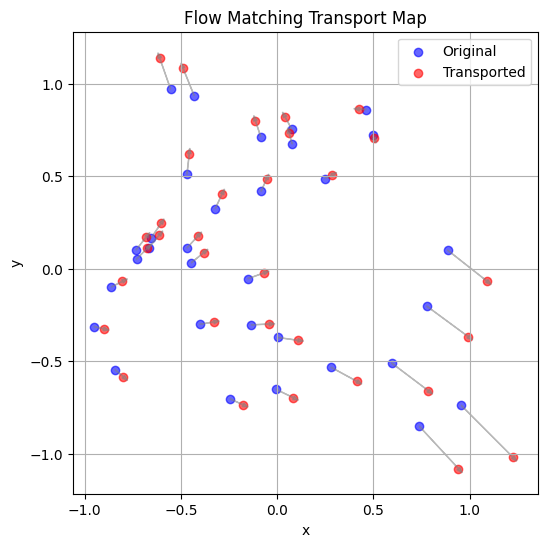

In [3]:
import jax
import jax.numpy as jnp
import numpy as np
import optax
import matplotlib.pyplot as plt

from ott import datasets
from ott.neural.networks.velocity_field import VelocityField
from ott.neural.methods.flows.otfm import OTFlowMatching
from ott.neural.methods.flows.dynamics import ConstantNoiseFlow
from ott.solvers import utils as solver_utils

def synthetic_loader(n_batches: int, batch_size: int, dim: int = 2):
    for _ in range(n_batches):
        batch = {
            "src_lin": np.random.uniform(-1, 1, size=(batch_size, dim)).astype(np.float32),
            "tgt_lin": np.random.uniform(-1, 1, size=(batch_size, dim)).astype(np.float32),
            "src_condition": np.random.uniform(-1, 1, size=(batch_size, dim)).astype(np.float32),
        }
        yield batch

def plot_transport(source, transported, title="Flow Matching Transport"):
    plt.figure(figsize=(6,6))
    plt.scatter(source[:,0], source[:,1], c="blue", label="Original", alpha=0.6)
    plt.scatter(transported[:,0], transported[:,1], c="red", label="Transported", alpha=0.6)
    for i in range(source.shape[0]):
        plt.arrow(
            source[i,0], source[i,1],
            transported[i,0] - source[i,0],
            transported[i,1] - source[i,1],
            head_width=0.02, head_length=0.03, fc='gray', ec='gray', alpha=0.5
        )
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

def main():
    # Set training parameters
    n_batches = 20
    batch_size = 32
    n_iters = 10

    # Instantiate the velocity field using OTT's built-in class.
    vf = VelocityField(hidden_dims=[64, 64], output_dims=[2])
    
    # Instantiate a flow.
    flow = ConstantNoiseFlow(sigma=0.1)
    
    # Create an optimizer for the velocity field and a key for initialization.
    optimizer = optax.adam(1e-3)
    rng_init = jax.random.PRNGKey(0)

    # Build the OTFlowMatching model.
    ot_flow_matching = OTFlowMatching(
        vf, flow, time_sampler=solver_utils.uniform_sampler,
        rng=rng_init, optimizer=optimizer
    )

    # Create the synthetic data loader.
    loader = synthetic_loader(n_batches, batch_size)

    # Train the OTFlowMatching model.
    rng = jax.random.PRNGKey(42)
    logs = ot_flow_matching(loader, n_iters=n_iters, rng=rng)
    print("Training losses:", logs["loss"])

    # Create test data and transport using the learned velocity field.
    test_data = np.random.uniform(-1, 1, size=(batch_size, 2)).astype(np.float32)
    test_data = jnp.asarray(test_data)
    transported = ot_flow_matching.transport(test_data, t0=0.0, t1=1.0)
    
    print("Original test data (first 5 rows):")
    print(test_data[:5])
    print("Transported test data (first 5 rows):")
    print(transported[:5])
    
    # Visualize the transport plan.
    # Convert data to numpy array for plotting if necessary.
    source_np = np.array(test_data)
    transported_np = np.array(transported)
    plot_transport(source_np, transported_np, title="Flow Matching Transport Map")

if __name__ == "__main__":
    main()

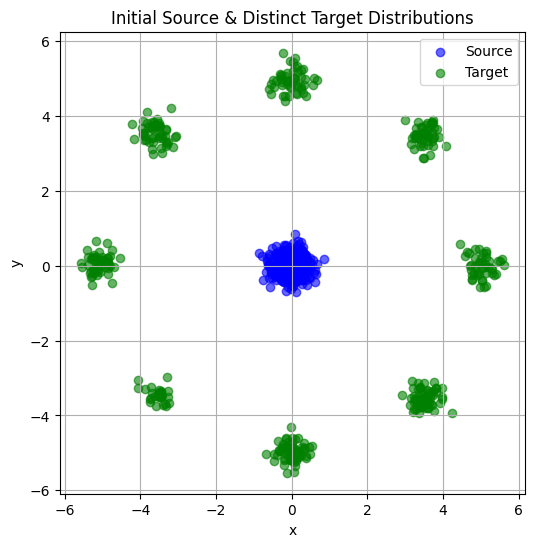

Epoch 1/10
Average loss for epoch 1: 2.0236
Epoch 2/10
Average loss for epoch 2: 1.4068
Epoch 3/10
Average loss for epoch 3: 1.3755
Epoch 4/10
Average loss for epoch 4: 1.3456
Epoch 5/10
Average loss for epoch 5: 1.3448
Epoch 6/10
Average loss for epoch 6: 1.3574
Epoch 7/10
Average loss for epoch 7: 1.3619
Epoch 8/10
Average loss for epoch 8: 1.3459
Epoch 9/10
Average loss for epoch 9: 1.3153
Epoch 10/10
Average loss for epoch 10: 1.3376
Total training done. Final loss: 1.1290004253387451
Original test data (first 5 rows):
[[ 0.12216712  0.03956028]
 [-0.04882848  0.5526268 ]
 [-0.28353128  0.02702082]
 [ 0.15719321 -0.50066674]
 [ 0.20921074 -0.03818622]]
Transported test data (first 5 rows):
[[ 4.275827    0.5972572 ]
 [-0.15256026  5.8070655 ]
 [-4.9950867   0.07752541]
 [ 0.62765044 -5.3051605 ]
 [ 4.7847147  -0.2705764 ]]


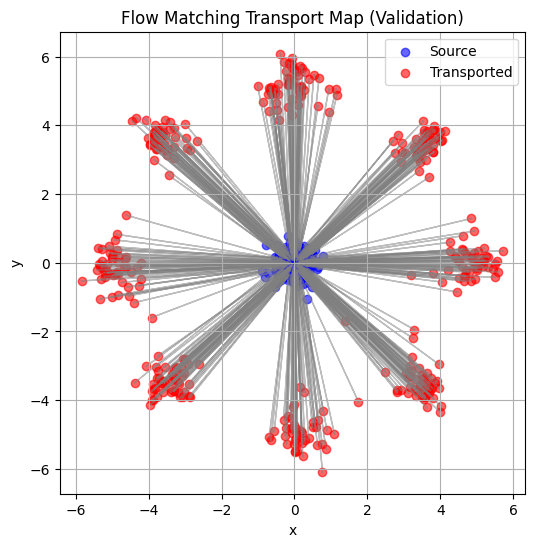

In [18]:
import jax
import jax.numpy as jnp
import numpy as np
import optax
import matplotlib.pyplot as plt
import time
from ott import datasets
from ott.neural.networks.velocity_field import VelocityField
from ott.neural.methods.flows.otfm import OTFlowMatching
from ott.neural.methods.flows.dynamics import ConstantNoiseFlow
from ott.solvers import utils as solver_utils

def loader_from_dataset(ds, n_batches):
    # Wrap the dataset iterators into a generator yielding batches.
    # We modify the target distribution (tgt_lin) to be distinct by scaling and shifting.
    for _ in range(n_batches):
        src = next(ds.source_iter)
        tgt = next(ds.target_iter)
        # Make target more distinct: scale and translate.
        tgt_mod = tgt 
        yield {"src_lin": src, "tgt_lin": tgt_mod, "src_condition": src}

def plot_initial(source, target, title="Initial Distributions"):
    plt.figure(figsize=(6,6))
    plt.scatter(source[:, 0], source[:, 1], c="blue", label="Source", alpha=0.6)
    plt.scatter(target[:, 0], target[:, 1], c="green", label="Target", alpha=0.6)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_transport(source, transported, title="Flow Matching Transport"):
    plt.figure(figsize=(6,6))
    plt.scatter(source[:, 0], source[:, 1], c="blue", label="Source", alpha=0.6)
    plt.scatter(transported[:, 0], transported[:, 1], c="red", label="Transported", alpha=0.6)
    for i in range(source.shape[0]):
        plt.arrow(
            source[i, 0],
            source[i, 1],
            transported[i, 0] - source[i, 0],
            transported[i, 1] - source[i, 1],
            head_width=0.02, head_length=0.03, fc='gray', ec='gray', alpha=0.5
        )
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

def main():
    # Get OTT's prepackaged Gaussian mixture sampler.
    num_samples_visualize = 400
    (train_dataloaders, valid_dataloaders, input_dim) = datasets.create_gaussian_mixture_samplers(
        name_source="simple",
        name_target="circle",
        train_batch_size=num_samples_visualize,
        valid_batch_size=num_samples_visualize,
    )
    
    valid_source = next(valid_dataloaders.source_iter)
    valid_target = next(valid_dataloaders.target_iter)
    valid_target_mod = valid_target
    plot_initial(valid_source, valid_target_mod, title="Initial Source & Distinct Target Distributions")
    
    # Training setup
    n_epochs = 10
    n_train_batches = 200
    n_iters_per_epoch = n_train_batches  # Assuming one step per batch
    
    # Model setup
    vf = VelocityField(hidden_dims=[128, 128,128], output_dims=[2])
    flow = ConstantNoiseFlow(sigma=0.1)
    optimizer = optax.adabelief(1e-3)
    rng_init = jax.random.PRNGKey(0)
    ot_flow_matching = OTFlowMatching(
        vf, flow, time_sampler=solver_utils.uniform_sampler,
        rng=rng_init, optimizer=optimizer
    )

    
    all_losses = []

    for epoch in range(n_epochs):
        print(f"Epoch {epoch + 1}/{n_epochs}")
        rng = jax.random.PRNGKey(int(time.time()))
        train_loader = loader_from_dataset(train_dataloaders, n_train_batches)
        logs = ot_flow_matching(train_loader, n_iters=n_iters_per_epoch, rng=rng)
        epoch_loss = logs["loss"]
        all_losses.extend(epoch_loss)
        print(f"Average loss for epoch {epoch + 1}: {np.mean(epoch_loss):.4f}")
    
    print("Total training done. Final loss:", all_losses[-1])

    # Evaluation
    valid_source = next(valid_dataloaders.source_iter)
    valid_target = next(valid_dataloaders.target_iter)
    valid_target_mod = valid_target 

    test_data = jnp.asarray(valid_source)
    transported = ot_flow_matching.transport(test_data, t0=0.0, t1=1.0)
    
    print("Original test data (first 5 rows):")
    print(test_data[:5])
    print("Transported test data (first 5 rows):")
    print(transported[:5])

    # Visualization
    source_np = np.array(test_data)
    transported_np = np.array(transported)
    plot_transport(source_np, transported_np, title="Flow Matching Transport Map (Validation)")

    
if __name__ == "__main__":
    main()

## Step 1: Import Required Libraries

In [1]:
import jax
import jax.numpy as jnp
import numpy as np
import optax
import matplotlib.pyplot as plt
import time
from ott import datasets
from ott.neural.networks.velocity_field import VelocityField
from ott.neural.methods.flows.otfm import OTFlowMatching
from ott.neural.methods.flows.dynamics import ConstantNoiseFlow
from ott.solvers import utils as solver_utils

## Step 2: Define Helper Functions

Define utility functions for loading data and visualizing distributions.


In [2]:
def loader_from_dataset(ds, n_batches):
    for _ in range(n_batches):
        src = next(ds.source_iter)
        tgt = next(ds.target_iter)
        tgt_mod = tgt  # Modify target distribution if needed
        yield {"src_lin": src, "tgt_lin": tgt_mod, "src_condition": src}

def plot_initial(source, target, title="Initial Distributions"):
    plt.figure(figsize=(6,6))
    plt.scatter(source[:, 0], source[:, 1], c="blue", label="Source", alpha=0.6)
    plt.scatter(target[:, 0], target[:, 1], c="green", label="Target", alpha=0.6)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_transport(source, transported, title="Flow Matching Transport"):
    plt.figure(figsize=(6,6))
    plt.scatter(source[:, 0], source[:, 1], c="blue", label="Source", alpha=0.6)
    plt.scatter(transported[:, 0], transported[:, 1], c="red", label="Transported", alpha=0.6)
    for i in range(source.shape[0]):
        plt.arrow(
            source[i, 0],
            source[i, 1],
            transported[i, 0] - source[i, 0],
            transported[i, 1] - source[i, 1],
            head_width=0.02, head_length=0.03, fc='gray', ec='gray', alpha=0.5
        )
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

## Step 3: Load and Visualize Data

Use OTT's prepackaged Gaussian mixture samplers to generate source and target distributions.

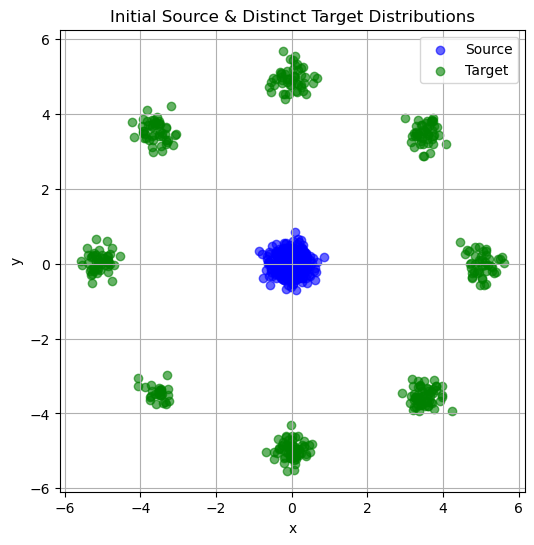

In [3]:
num_samples_visualize = 400
(train_dataloaders, valid_dataloaders, input_dim) = datasets.create_gaussian_mixture_samplers(
    name_source="simple",
    name_target="circle",
    train_batch_size=num_samples_visualize,
    valid_batch_size=num_samples_visualize,
)

valid_source = next(valid_dataloaders.source_iter)
valid_target = next(valid_dataloaders.target_iter)
valid_target_mod = valid_target
plot_initial(valid_source, valid_target_mod, title="Initial Source & Distinct Target Distributions")

## Step 4: Set Up the Model and Training

Define the velocity field, flow dynamics, and optimizer. Then, initialize the OTFlowMatching model.

In [4]:
vf = VelocityField(hidden_dims=[128, 128, 128], output_dims=[2])
flow = ConstantNoiseFlow(sigma=0.1)
optimizer = optax.adabelief(1e-3)
rng_init = jax.random.PRNGKey(0)

ot_flow_matching = OTFlowMatching(
    vf, flow, time_sampler=solver_utils.uniform_sampler,
    rng=rng_init, optimizer=optimizer
)

## Step 5: Train the Model

Train the model over multiple epochs and track the loss.

In [5]:
n_epochs = 10
n_train_batches = 200
n_iters_per_epoch = n_train_batches

all_losses = []

for epoch in range(n_epochs):
    print(f"Epoch {epoch + 1}/{n_epochs}")
    rng = jax.random.PRNGKey(int(time.time()))
    train_loader = loader_from_dataset(train_dataloaders, n_train_batches)
    logs = ot_flow_matching(train_loader, n_iters=n_iters_per_epoch, rng=rng)
    epoch_loss = logs["loss"]
    all_losses.extend(epoch_loss)
    print(f"Average loss for epoch {epoch + 1}: {np.mean(epoch_loss):.4f}")

print("Total training done. Final loss:", all_losses[-1])

Epoch 1/10
Average loss for epoch 1: 2.0046
Epoch 2/10
Average loss for epoch 2: 1.3875
Epoch 3/10
Average loss for epoch 3: 1.3734
Epoch 4/10
Average loss for epoch 4: 1.3335
Epoch 5/10
Average loss for epoch 5: 1.3467
Epoch 6/10
Average loss for epoch 6: 1.3421
Epoch 7/10
Average loss for epoch 7: 1.3446
Epoch 8/10
Average loss for epoch 8: 1.3380
Epoch 9/10
Average loss for epoch 9: 1.3227
Epoch 10/10
Average loss for epoch 10: 1.3278
Total training done. Final loss: 1.084540605545044


## Step 6: Evaluate and Visualize the Results

Transport the source distribution to the target and visualize the results.

Original test data (first 5 rows):
[[ 0.12216712  0.03956028]
 [-0.04882848  0.5526268 ]
 [-0.28353128  0.02702082]
 [ 0.15719321 -0.50066674]
 [ 0.20921074 -0.03818622]]
Transported test data (first 5 rows):
[[ 3.4471695   2.3721018 ]
 [-0.13994141  5.6263266 ]
 [-5.1362014  -0.11494128]
 [ 0.36193064 -5.3544984 ]
 [ 4.753335   -0.13780381]]


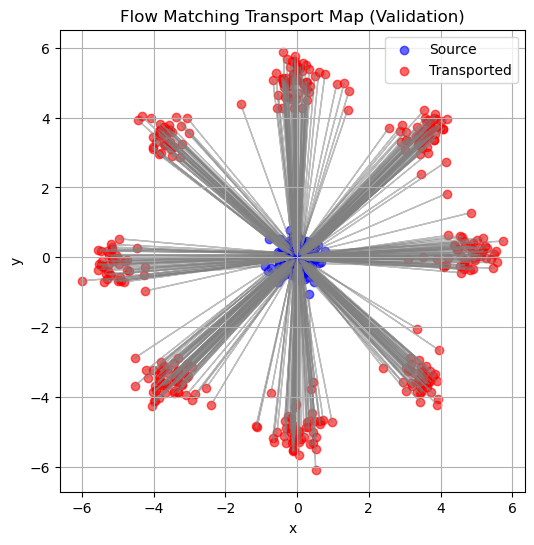

In [6]:
valid_source = next(valid_dataloaders.source_iter)
valid_target = next(valid_dataloaders.target_iter)
valid_target_mod = valid_target

test_data = jnp.asarray(valid_source)
transported = ot_flow_matching.transport(test_data, t0=0.0, t1=1.0)

print("Original test data (first 5 rows):")
print(test_data[:5])
print("Transported test data (first 5 rows):")
print(transported[:5])

source_np = np.array(test_data)
transported_np = np.array(transported)
plot_transport(source_np, transported_np, title="Flow Matching Transport Map (Validation)")

## Step 7: Run the Main Function

Finally, wrap everything into a `main()` function and execute it.


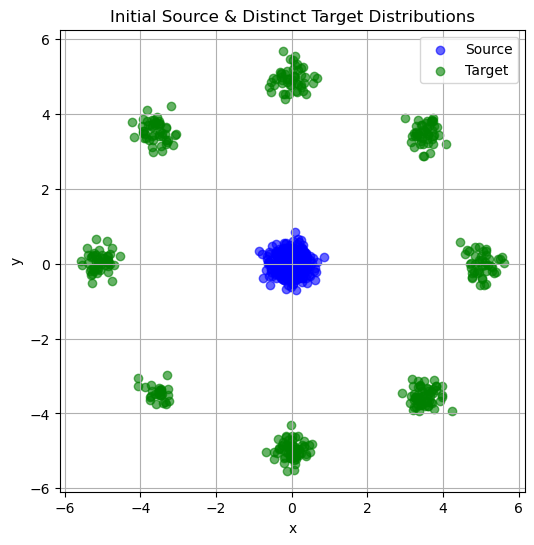

Epoch 1/10
Average loss for epoch 1: 2.0076
Epoch 2/10
Average loss for epoch 2: 1.4153
Epoch 3/10
Average loss for epoch 3: 1.3695
Epoch 4/10
Average loss for epoch 4: 1.3587
Epoch 5/10
Average loss for epoch 5: 1.3721
Epoch 6/10
Average loss for epoch 6: 1.3702
Epoch 7/10
Average loss for epoch 7: 1.3592
Epoch 8/10
Average loss for epoch 8: 1.3406
Epoch 9/10
Average loss for epoch 9: 1.3409
Epoch 10/10
Average loss for epoch 10: 1.3284
Total training done. Final loss: 1.3659948110580444
Original test data (first 5 rows):
[[ 0.12216712  0.03956028]
 [-0.04882848  0.5526268 ]
 [-0.28353128  0.02702082]
 [ 0.15719321 -0.50066674]
 [ 0.20921074 -0.03818622]]
Transported test data (first 5 rows):
[[ 4.411042    0.3122523 ]
 [-0.11206948  5.8501406 ]
 [-5.078423    0.04749829]
 [ 0.5654495  -5.2781    ]
 [ 4.6964602  -0.3067833 ]]


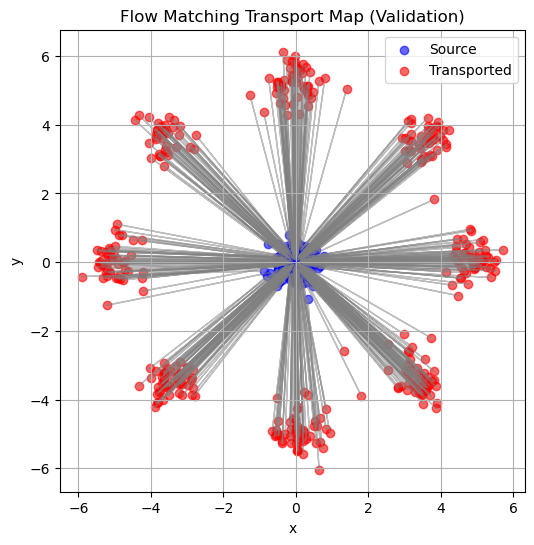

In [8]:
def main():
    # Get OTT's prepackaged Gaussian mixture sampler.
    num_samples_visualize = 400
    (train_dataloaders, valid_dataloaders, input_dim) = datasets.create_gaussian_mixture_samplers(
        name_source="simple",
        name_target="circle",
        train_batch_size=num_samples_visualize,
        valid_batch_size=num_samples_visualize,
    )
    
    valid_source = next(valid_dataloaders.source_iter)
    valid_target = next(valid_dataloaders.target_iter)
    valid_target_mod = valid_target
    plot_initial(valid_source, valid_target_mod, title="Initial Source & Distinct Target Distributions")
    
    # Training setup
    n_epochs = 10
    n_train_batches = 200
    n_iters_per_epoch = n_train_batches  # Assuming one step per batch
    
    # Model setup
    vf = VelocityField(hidden_dims=[128, 128,128], output_dims=[2])
    flow = ConstantNoiseFlow(sigma=0.1)
    optimizer = optax.adabelief(1e-3)
    rng_init = jax.random.PRNGKey(0)
    ot_flow_matching = OTFlowMatching(
        vf, flow, time_sampler=solver_utils.uniform_sampler,
        rng=rng_init, optimizer=optimizer
    )

    
    all_losses = []

    for epoch in range(n_epochs):
        print(f"Epoch {epoch + 1}/{n_epochs}")
        rng = jax.random.PRNGKey(int(time.time()))
        train_loader = loader_from_dataset(train_dataloaders, n_train_batches)
        logs = ot_flow_matching(train_loader, n_iters=n_iters_per_epoch, rng=rng)
        epoch_loss = logs["loss"]
        all_losses.extend(epoch_loss)
        print(f"Average loss for epoch {epoch + 1}: {np.mean(epoch_loss):.4f}")
    
    print("Total training done. Final loss:", all_losses[-1])

    # Evaluation
    valid_source = next(valid_dataloaders.source_iter)
    valid_target = next(valid_dataloaders.target_iter)
    valid_target_mod = valid_target 

    test_data = jnp.asarray(valid_source)
    transported = ot_flow_matching.transport(test_data, t0=0.0, t1=1.0)
    
    print("Original test data (first 5 rows):")
    print(test_data[:5])
    print("Transported test data (first 5 rows):")
    print(transported[:5])

    # Visualization
    source_np = np.array(test_data)
    transported_np = np.array(transported)
    plot_transport(source_np, transported_np, title="Flow Matching Transport Map (Validation)")

    
main()